<h1><b>인공지능개론 6주차 수업실습<br></b></h1>
<p>컴퓨터공학과 202136038 조성준</p>


---

<h1><b>Pytorch 분류(car_evaluation.csv)<br></b></h1>

---



<h2><b>0. 라이브러리 import(분류)</b></h2>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# pytorch관련 라이브러리
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchsummary import summary

<h2><b>1. 데이터 로딩</b></h2>

In [2]:
# URL
url = "https://raw.githubusercontent.com/harjotspahwa/Car-Evaluation/master/car_evaluation.csv"

# 컬럼 이름 지정
column_names = ['price',	'maint',	'doors',	'persons',	'lug_capacity',	'safety', 'output']

# URL에서 직접 CSV 불러오기
df = pd.read_csv(url, header=None, names=column_names)  # 이미 컬럼명이 포함된 경우는 header=0, 없으면 header=None + names=column_names

# 데이터 확인
df

,price,maint,doors,persons,lug_capacity,safety,output
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
...,...,...,...,...,...,...,...
1723,low,low,5more,more,med,med,good
1724,low,low,5more,more,med,high,vgood
1725,low,low,5more,more,big,low,unacc
1726,low,low,5more,more,big,med,good


In [3]:
# 컬렴명 확인
print(df.columns)

Index(['price', 'maint', 'doors', 'persons', 'lug_capacity', 'safety',
       'output'],
      dtype='object')


<h2><b>2. 결측치 확인</b></h2>

In [4]:
# 결측치 확인
print(df.isnull().sum())
# 확인 결과: 결측치가 확인되지않음

price           0
maint           0
doors           0
persons         0
lug_capacity    0
safety          0
output          0
dtype: int64


<h2><b>3. 레이블 확인(imbalanced data)</b></h2>
<li>타겟 변수(target)의 분포를 확인</li>

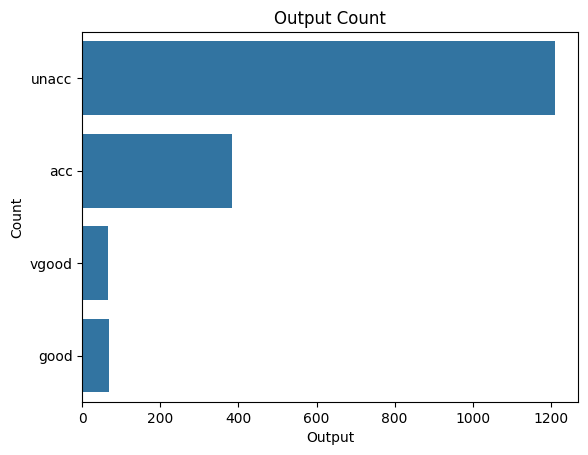

,count
output,
unacc,1210
acc,384
good,69
vgood,65


In [5]:
# 레이블 갯수 확인 (그래프)
sns.countplot(df['output'])
plt.xlabel("Output")
plt.ylabel("Count")
plt.title("Output Count")
plt.show()

# 레이블 갯수 확인 (숫자)
df['output'].value_counts()


<h2><b>4. 데이터 전처리</b></h2>

In [6]:
# 입력 변수와 출력 변수 분리
X = df.drop('output', axis=1)
y = df['output']

# 범주형 변수들 Label Encoding
label_encoders = {}
for column in X.columns:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column])
    label_encoders[column] = le

# 출력값도 Label Encoding
output_encoder = LabelEncoder()
y = output_encoder.fit_transform(y)

# numpy 배열로 변환
X = X.values
y = y.reshape(-1, 1)

# Tensor로 변환
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long).squeeze()

# 훈련/검증 데이터 분할
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42, stratify=y_tensor)

# DataLoader 생성
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 클래스 개수 확인
num_classes = len(output_encoder.classes_)


<h2><b>5. 모델 정의</b></h2>

In [7]:
class CarClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(CarClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.model(x)

# 하이퍼파라미터 설정
input_dim = X.shape[1]
hidden_dim = 64
output_dim = num_classes

model = CarClassifier(input_dim, hidden_dim, output_dim)
summary(model, input_size=(input_dim,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]             448
              ReLU-2                   [-1, 64]               0
           Dropout-3                   [-1, 64]               0
            Linear-4                   [-1, 64]           4,160
              ReLU-5                   [-1, 64]               0
           Dropout-6                   [-1, 64]               0
            Linear-7                    [-1, 4]             260
Total params: 4,868
Trainable params: 4,868
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


<h2><b>6. 손실함수 및 옵티마이져 기법 정의</b></h2>

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

<h2><b>7. 모델 학습 </b></h2>

In [9]:
epochs = 50
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct / total)

    # 검증
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_correct / val_total)

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]*100:.2f}%, Val Acc: {val_accuracies[-1]*100:.2f}%")


Epoch [1/50], Train Loss: 0.9456, Val Loss: 0.8086, Train Acc: 68.45%, Val Acc: 69.94%
Epoch [2/50], Train Loss: 0.8025, Val Loss: 0.7306, Train Acc: 70.12%, Val Acc: 69.94%
Epoch [3/50], Train Loss: 0.7293, Val Loss: 0.6838, Train Acc: 70.19%, Val Acc: 70.23%
Epoch [4/50], Train Loss: 0.7078, Val Loss: 0.6546, Train Acc: 70.77%, Val Acc: 70.81%
Epoch [5/50], Train Loss: 0.6732, Val Loss: 0.6311, Train Acc: 70.26%, Val Acc: 71.10%
Epoch [6/50], Train Loss: 0.6467, Val Loss: 0.6046, Train Acc: 70.12%, Val Acc: 71.68%
Epoch [7/50], Train Loss: 0.6289, Val Loss: 0.5797, Train Acc: 71.92%, Val Acc: 72.83%
Epoch [8/50], Train Loss: 0.6026, Val Loss: 0.5519, Train Acc: 73.23%, Val Acc: 76.30%
Epoch [9/50], Train Loss: 0.5950, Val Loss: 0.5293, Train Acc: 73.15%, Val Acc: 76.88%
Epoch [10/50], Train Loss: 0.5684, Val Loss: 0.5071, Train Acc: 75.11%, Val Acc: 78.03%
Epoch [11/50], Train Loss: 0.5412, Val Loss: 0.4827, Train Acc: 76.34%, Val Acc: 80.35%
Epoch [12/50], Train Loss: 0.5349, Val Lo

<h2><b>8. 학습곡선 시각화 </b></h2>

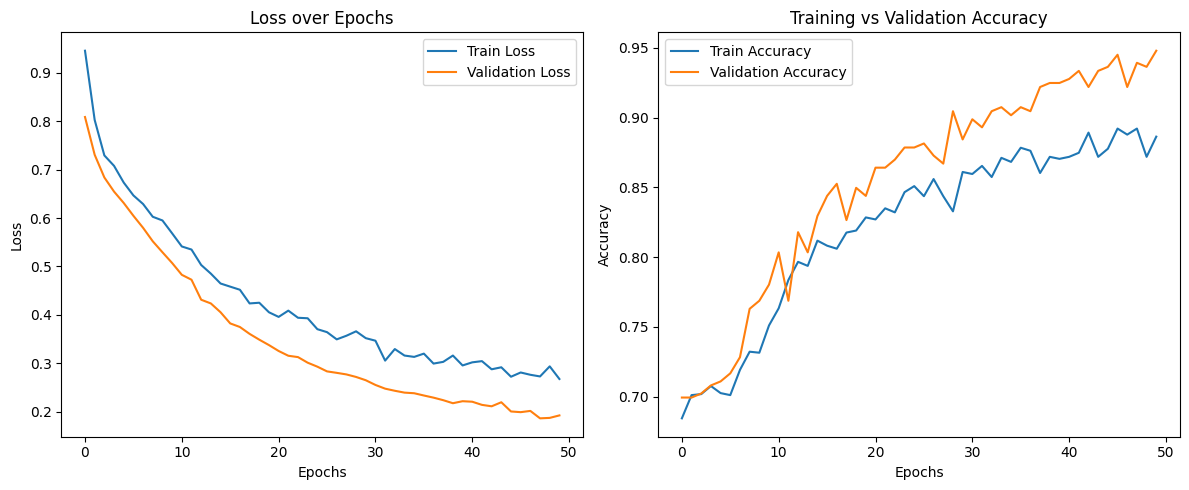

In [10]:
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


<h2><b>9. 모델 평가 </b></h2>

Precision: 0.9497530737637335
Recall: 0.9479768786127167
F1 Score: 0.9479285816810843
ROC AUC Score: 0.9561713415735452


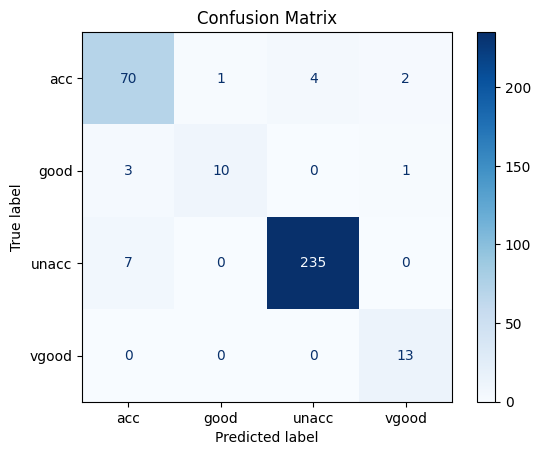

In [11]:
# 예측
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.tolist())
        y_true.extend(labels.tolist())

# 평가 지표
print("Precision:", precision_score(y_true, y_pred, average='weighted'))
print("Recall:", recall_score(y_true, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_true, y_pred, average='weighted'))
print("ROC AUC Score:", roc_auc_score(pd.get_dummies(y_true), pd.get_dummies(y_pred), average='weighted', multi_class='ovr'))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=output_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
